<a href="https://colab.research.google.com/github/abishek-bupathi/dog-breed-identification/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!unzip "/content/drive/My Drive/Dog vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog vision/"

# Multiclass Dog breed classification

This notebook builds multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

### 1. Problem

Identifying the breed of the dog given an image of a dog.

### 2. Data

The data used from Kaggle's dog breed identification competition

https://www.kaggle.com/c/dog-breed-identification/data

### 3. Evaluation

A file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

### 4. Features

Information about the data:
- The data is in the form of images(unstructured) so its best method is to use deep learning/ transfer learning
- There are 120 breeds of dogs (multi-class: 120 different classes)
- There are 10,000+ images in the training set (images with labels)
- There are 10,000+ images in the test set (images without labels)




## 0. Getting the workspace ready
- Import TensorFlow 2.x
- Import TensorFlow Hub
- Initialize and use GPU

In [1]:
# import TensorFlow 2.x and other neccessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU available !" if tf.config.list_physical_devices("GPU")else "GPU not available :(")

TF version:  2.2.0
TF Hub version:  0.8.0
GPU available(Yes!)


## 1. Getting the Data Ready (Turning into Tensors)

All data should be converted into numeric

In [5]:
# Checking the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     8c3c5a2ab2212dae4745f271854101b9  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


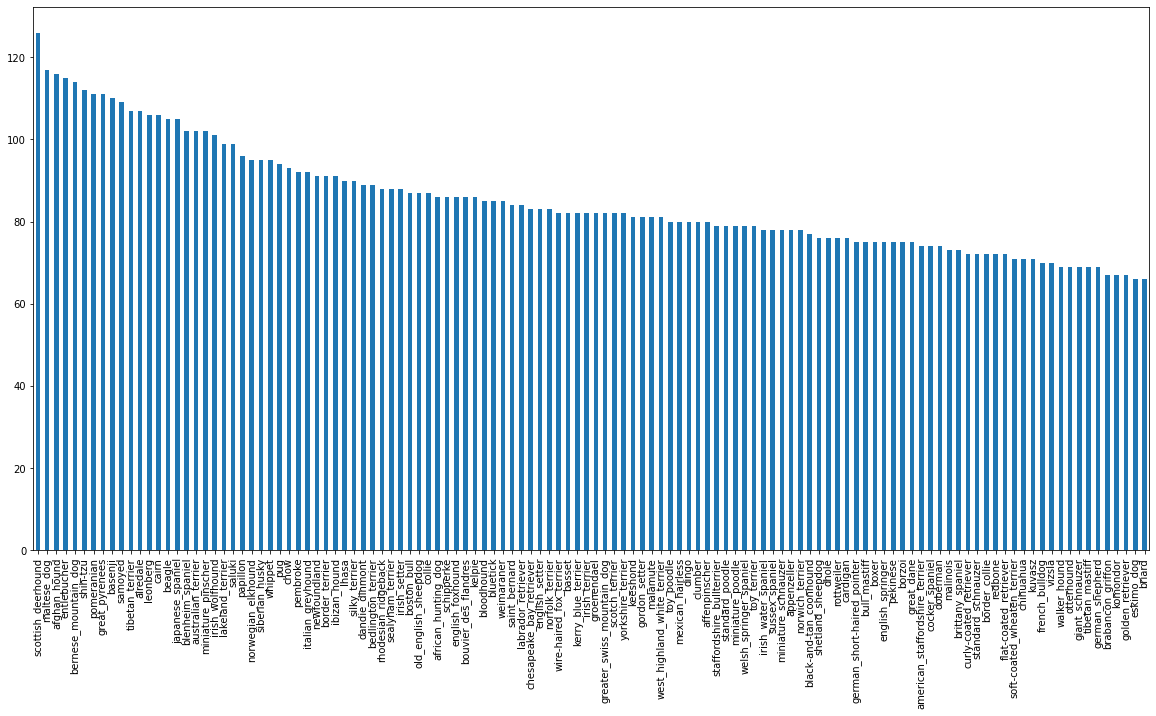

In [8]:
# Number of images of each breed
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10));

In [9]:
# median number of images per class
labels_csv["breed"].value_counts().median()

82.0

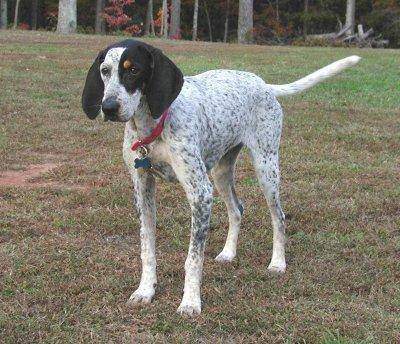

In [20]:
# View an image
from IPython.display import Image
Image("/content/drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels
 
 Get list of all image file pathnames

In [27]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog vision/train/"+fname+".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [29]:
# Check whether number of file names matches the number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog vision/train")) == len(filenames):
  print("File names match actual amount of file !")
else:
  print("Filename do not match the actual amount of files")

File names match actual amount of file


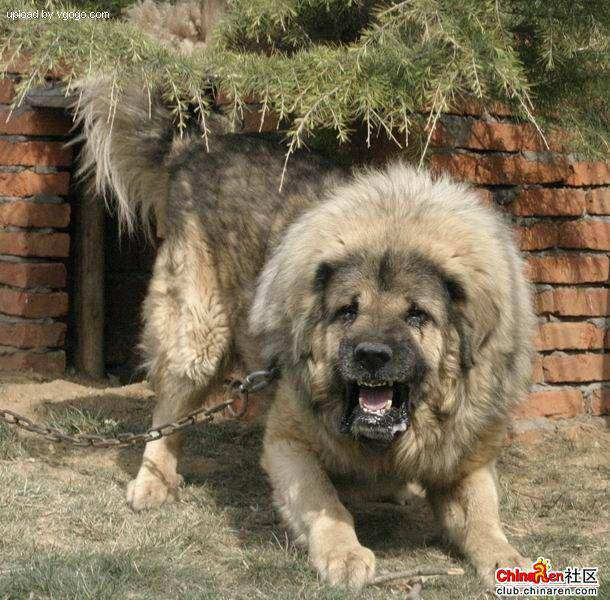

In [34]:
Image(filenames[9000])

In [33]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [36]:
# Prepare labels
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [38]:
# Checking for missing data
if len(labels) == len (filenames):
  print("Number of labels matches number of filename !")
else:
  print("Number of labels does not match with number of filename")

Number of labels matches number of filename !


In [40]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [41]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [43]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [44]:
# Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [45]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
